In [4]:
from pathlib import Path
from src.knn_model.dataset import get_train_test_df
from src.knn_model.model import df_to_matrix, get_id_of_user_based_on_sample, transform_bucket_values
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
train_df, test_df = get_train_test_df(data_path=Path("dataset/Keystrokes/files"), num_of_users=100)
train_matrix = df_to_matrix(train_df)
test_matrix = df_to_matrix(test_df)

  0%|          | 101/168595 [00:00<04:52, 575.96it/s]
102it [00:00, 5359.39it/s]
102it [00:00, 5596.43it/s]


# Lets compare two random distributions

0 32 [156, 163, 98, 166, 158, 119, 100, 116, 85, 201, 147, 147, 153, 100, 142, 138, 173, 156, 159, 151, 121, 108, 103, 70, 132, 131, 115, 169, 88, 138, 57, 94, 140, 133, 123, 139, 70, 100, 100, 113, 131, 114, 120, 115, 119, 116, 89, 131, 168, 126, 138, 114, 100, 128, 90, 94, 101, 100, 134, 107, 156, 117, 255, 123, 99, 120, 85, 134, 51, 66, 164, 152, 133, 105, 75, 106, 109, 113, 92, 78, 84, 71, 101, 136]


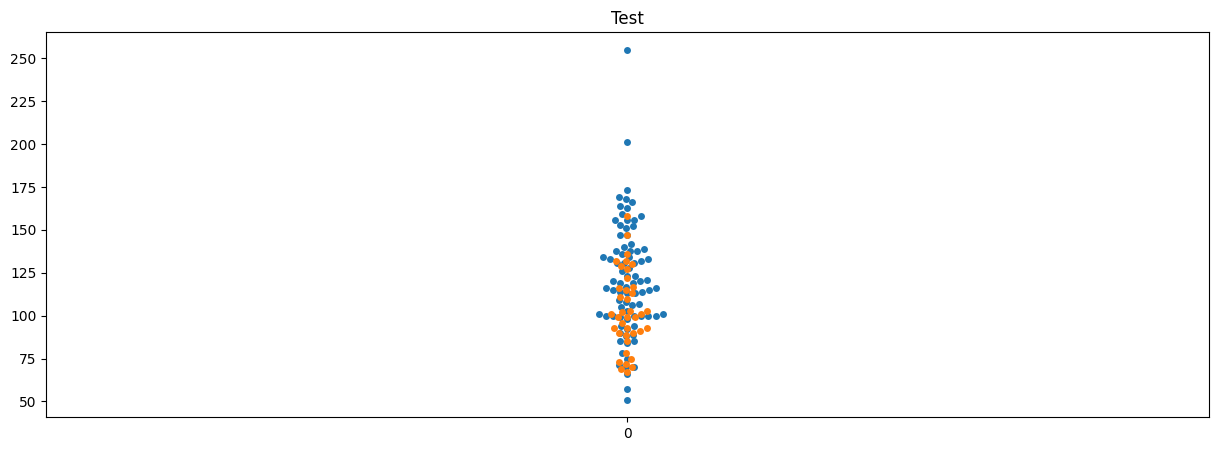

In [13]:
plt.figure(figsize=(15,5))
for user_id in range(len(train_matrix)):
    for bucket_id in range(len(train_matrix[user_id])):
        if len(train_matrix[user_id][bucket_id]) > 0 and bucket_id > 16:
            print(user_id, bucket_id, train_matrix[user_id][bucket_id])
            sns.swarmplot(y=train_matrix[user_id][bucket_id],x=[user_id] * len(train_matrix[user_id][bucket_id])).set_title('Train')
            sns.swarmplot(y=test_matrix[user_id][bucket_id],x=[user_id] * len(test_matrix[user_id][bucket_id])).set_title('Test')
            break
    break

In [19]:
train_dist = train_matrix[0][32]
test_dist = test_matrix[0][32]

## Kolmogorov-Smirnov Test (KS Test)

In [20]:
from scipy.stats import ks_2samp

# Assuming data1 and data2 are your two distributions
ks_statistic, p_value = ks_2samp(train_dist, test_dist)
print("KS Statistic:", ks_statistic)
print("P-Value:", p_value)


KS Statistic: 0.28205128205128205
P-Value: 0.022482702567332574


## t-Test (for Normally Distributed Data)

In [21]:
from scipy.stats import ttest_ind

# Assuming data1 and data2 are your two distributions
t_statistic, p_value = ttest_ind(train_dist, test_dist)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: 2.983701388082839
P-Value: 0.003445761859580711


## Mann-Whitney U Test (for Non-Normal Data)

In [22]:
from scipy.stats import mannwhitneyu

# Assuming data1 and data2 are your two distributions
u_statistic, p_value = mannwhitneyu(train_dist, test_dist)
print("U-Statistic:", u_statistic)
print("P-Value:", p_value)


U-Statistic: 2196.5
P-Value: 0.002418350481213636


# Visualization

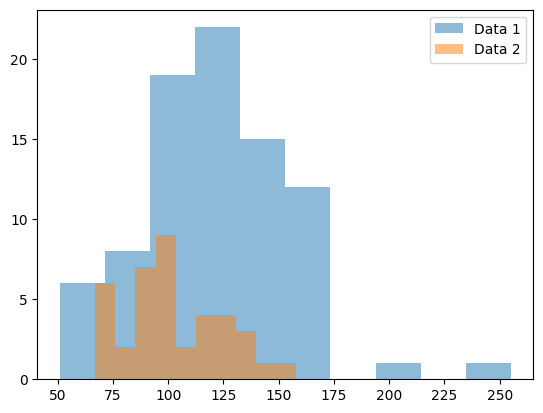

In [23]:
import matplotlib.pyplot as plt

# Assuming data1 and data2 are your two distributions
plt.hist(train_dist, alpha=0.5, label='Data 1')
plt.hist(test_dist, alpha=0.5, label='Data 2')
plt.legend(loc='upper right')
plt.show()


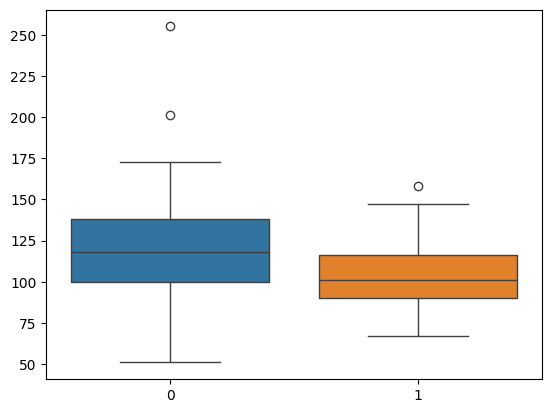

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data1 and data2 are your two distributions (as arrays, lists, or pandas Series)
sns.boxplot(data=[train_dist, test_dist])
plt.show()


/var/folders/1j/nxhw13d53355cpbhwft_q_400000gp/T/ipykernel_29980/2368501823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_dist, label='Data 1', shade=True)
/var/folders/1j/nxhw13d53355cpbhwft_q_400000gp/T/ipykernel_29980/2368501823.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_dist, label='Data 2', shade=True)


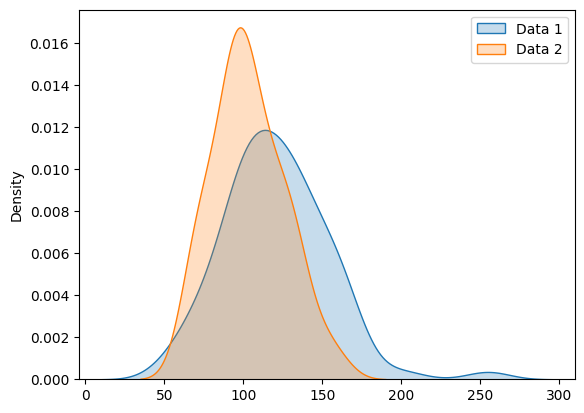

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data1 and data2 are your two distributions (as arrays, lists, or pandas Series)
sns.kdeplot(train_dist, label='Data 1', shade=True)
sns.kdeplot(test_dist, label='Data 2', shade=True)
plt.legend()
plt.show()


## KL Divergence is not symmetric

In [45]:
from scipy.special import kl_div
from scipy.interpolate import interp1d
import numpy as np

# Assuming p and q are your two probability distributions (as arrays, lists, or pandas Series)
# Make sure both p and q have the same length

p = np.array(train_dist)
q = np.array(test_dist)

# Assuming data1 and data2 are your distributions represented as arrays
# Interpolate the data to create distributions with the same number of points
interp_func1 = interp1d(range(len(p)), p, kind='linear')
interp_func2 = interp1d(range(len(q)), q, kind='linear')

# Generate new interpolated data with the same number of points
if len(p) > len(q):
    inter_q = interp_func2(np.linspace(0, len(q) - 1, len(p)))
    inter_p = p
else:
    inter_q = q
    inter_p = interp_func1(np.linspace(0, len(p) - 1, len(q)))


# Compute KL Divergence from q to p
kl_divergence = np.sum(np.where(inter_p != 0, inter_p * np.log(inter_p / inter_q), 0))

print("KL Divergence:", kl_divergence)


KL Divergence: 2045.5046728961383


## Jensen-Shannon (JS) Divergence for symmetric comparition

In [46]:
from scipy.spatial import distance

# Assuming p and q are your two probability distributions (as arrays, lists, or pandas Series)
# Make sure both p and q have the same length
p = np.array(train_dist)
q = np.array(test_dist)

# Assuming data1 and data2 are your distributions represented as arrays
# Interpolate the data to create distributions with the same number of points
interp_func1 = interp1d(range(len(p)), p, kind='linear')
interp_func2 = interp1d(range(len(q)), q, kind='linear')

# Generate new interpolated data with the same number of points
if len(p) > len(q):
    inter_q = interp_func2(np.linspace(0, len(q) - 1, len(p)))
    inter_p = p
else:
    inter_q = q
    inter_p = interp_func1(np.linspace(0, len(p) - 1, len(q)))

# Compute JS Divergence
js_divergence = distance.jensenshannon(inter_p, inter_q, 2.0)  # 2.0 represents the base of the logarithm

print("JS Divergence:", js_divergence)


JS Divergence: 0.13231101439383988
